In [ ]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
import torch
import pandas as pd
import certifi
import pymongo
import requests
from pathlib import Path
import os
import glob
import logging
import json  # To parse the response into JSON
import re
from collections import Counter
from datetime import datetime

: 

In [ ]:
!python -m ipykernel install --user --name=myenv

: 

In [ ]:
!pip install ultralytics opencv-python torch numpy matplotlib pillow torchvision tqdm pandas certifi pymongo requests

: 

In [2]:
from transformers import VisionEncoderDecoderModel  # For loading the pretrained Hugging Face model
from transformers import TrOCRProcesso
from transformers import BertTokenizer, BertModel

ValueError: Unable to compare versions for packaging>=20.0: need=20.0 found=None. This is unusual. Consider reinstalling packaging.

In [43]:
orignal_path="/Users/sarahhaddad/Documents/GitHub/TrOCR/data/cheques/image (30).jpg"

In [44]:
banques = [
    "BDL",
    "BNA",
    "BNP",
    "CCP",
    "CPA"
]

In [45]:
# CNN Model for Cheque Classification
target_size = (224, 224)
class ChequeClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(ChequeClassifier, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                # Pooling layer 1
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Convolutional layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                # Pooling layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Convolutional layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                 # Pooling layer 3
        )
        # Update input dimension based on the output from feature_extractor
        self.fc_input_size = 128 * (target_size[0] // 8) * (target_size[1] // 8)  # Adjusted for input size
        self.fc = nn.Linear(self.fc_input_size, 256)  # Fully connected layer
        self.output = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return self.output(x)

model = ChequeClassifier(num_classes=5)  # Initialize the model structure
model.load_state_dict(torch.load("/Users/sarahhaddad/Documents/GitHub/TrOCR/models/cheque_classifier.pth"))  # Load the saved state
model.eval()  # Set the model to evaluation mode

ChequeClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=5, bias=True)
)

In [46]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image)  # Apply the same transformations as the training data
    image = image.unsqueeze(0)  # Add batch dimension
    return image

test_transforms = transforms.Compose([
    transforms.Resize(target_size),  # Ensure test data is the same size as training data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the new image
new_image = preprocess_image(orignal_path, test_transforms)

# Get the model's prediction
with torch.no_grad():
    output = model(new_image)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {banques[predicted.item()]}')
    banque_emetrice=banques[predicted.item()]

Predicted class: CCP


# Section: Prétraitement des Images

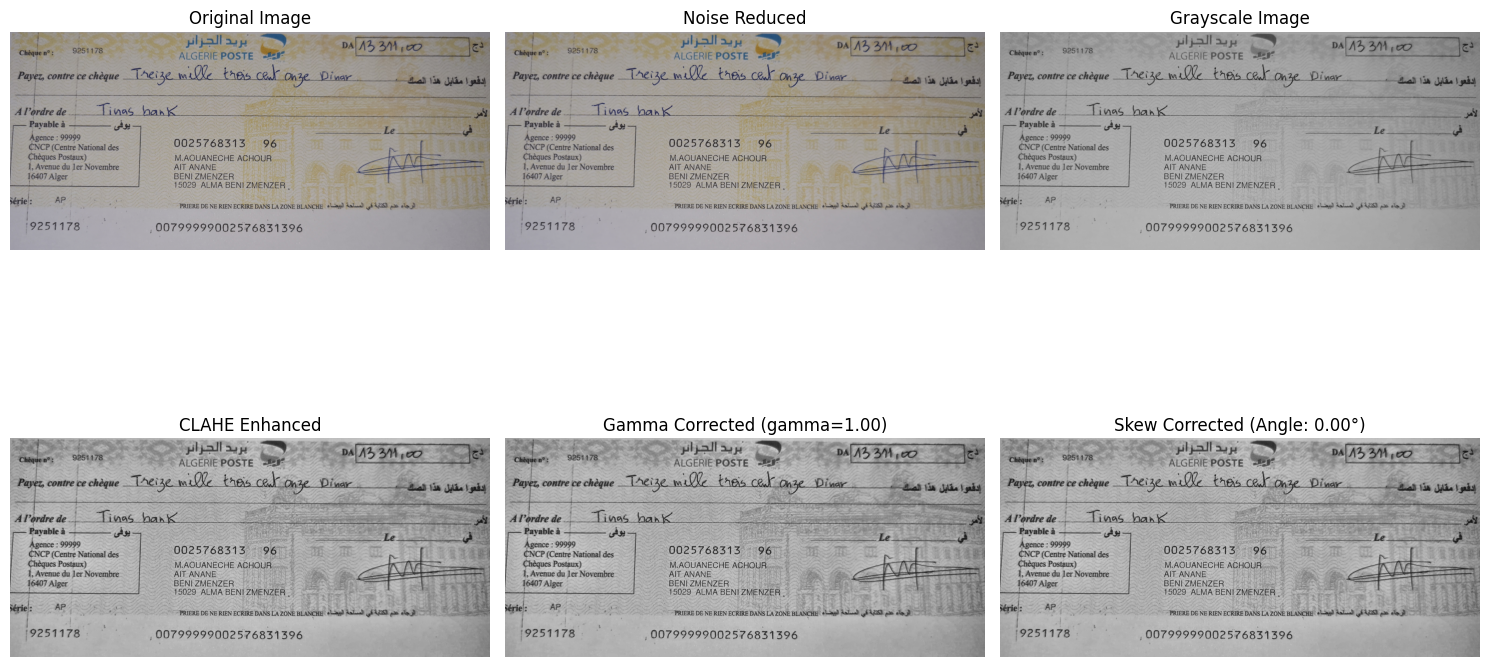

Image processing completed successfully


In [47]:
# Estime le niveau de bruit d'une image en calculant son écart-type.
def estimate_noise(image):
    return np.std(image)

# Estime la luminosité d'une image en calculant la moyenne des niveaux de gris
def estimate_brightness(image):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    return np.mean(gray_image)

# Applique CLAHE (Contraste adaptatif par histogramme) pour améliorer le contraste d'une image en niveaux de gris.
def apply_clahe(gray_image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Args:
        gray_image (numpy array): Image en niveaux de gris.
        clip_limit (float): Limite du contraste pour éviter une sur-amplification.
        tile_grid_size (tuple): Taille de la grille pour la partition de l'image.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray_image)

# Ajuste la correction gamma pour améliorer la visibilité de l'image.
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Corrige l'inclinaison (skew) d'une image de manière adaptative en détectant les lignes via la transformée de Hough.
def adaptive_skew_correction(image, max_angle=2):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None:
        angles = []
        for line in lines[:10]:  # Consider up to 10 lines
            rho, theta = line[0]
            angle = (theta * 180 / np.pi) - 90
            angles.append(angle)

        median_angle = np.median(angles)

        if 0 < abs(median_angle) <= max_angle:
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
            corrected_image = cv2.warpAffine(image, M, (w, h),
                                             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            return corrected_image, median_angle

    return image, 0

def preprocess_cheque_image(image_path):
    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")

    # Step 1: Noise Reduction (Bilateral Filter)
    noise_level = estimate_noise(image)
    sigmaColor = 50 + (noise_level / 10)
    sigmaSpace = sigmaColor
    denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

    # Step 2: Convert to Grayscale
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply CLAHE for contrast enhancement
    clahe_image = apply_clahe(gray_image)

    # Step 4: Adjust gamma for better visibility
    brightness = estimate_brightness(clahe_image)
    gamma = 1.0 if brightness > 127 else 1.2  # Adjust gamma if image is dark
    gamma_corrected = adjust_gamma(clahe_image, gamma)

    # Step 5: Selective Skew Correction
    corrected_image, angle = adaptive_skew_correction(gamma_corrected, max_angle=2)

    # Display Results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Noise Reduced")
    axes[1].axis('off')

    axes[2].imshow(gray_image, cmap='gray')
    axes[2].set_title("Grayscale Image")
    axes[2].axis('off')

    axes[3].imshow(clahe_image, cmap='gray')
    axes[3].set_title("CLAHE Enhanced")
    axes[3].axis('off')

    axes[4].imshow(gamma_corrected, cmap='gray')
    axes[4].set_title(f"Gamma Corrected (gamma={gamma:.2f})")
    axes[4].axis('off')

    axes[5].imshow(corrected_image, cmap='gray')
    axes[5].set_title(f"Skew Corrected (Angle: {angle:.2f}°)")
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()
    cv2.imwrite("corrected.png", corrected_image)

    return corrected_image

result = preprocess_cheque_image(orignal_path)
if result is not None:
    print("Image processing completed successfully")
else:
    print("Image processing failed")

# Section: Détection avec YOLOv8


0: 384x800 1 line1, 1 numbers, 862.9ms
Speed: 38.5ms preprocess, 862.9ms inference, 31.3ms postprocess per image at shape (1, 3, 384, 800)


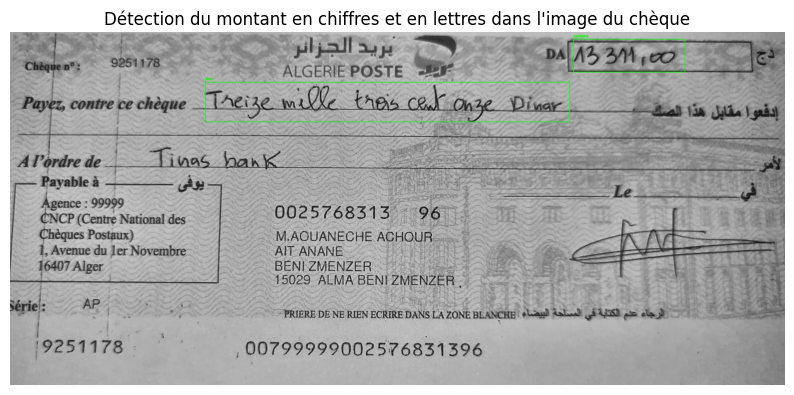

In [2]:
model = YOLO('/Users/sarahhaddad/Documents/GitHub/TrOCR/models/model_yolo/best.pt')
model = model.to('cpu')

img_path = 'corrected.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference on the image
results = model(image)

# Copy the original image for drawing all boxes
img_with_boxes = np.copy(image)

save_dir = Path('./cropped_images')
save_dir.mkdir(parents=True, exist_ok=True)

# Effectue la détection sur l'image corrigée
# Les objets détectés (comme les numéros ou les chiffres) sont ensuite recadrés et enregistrés.
for r in results:
    for i, box in enumerate(r.boxes):
        # Extract the class label and confidence score
        cls_id = int(box.cls[0])
        label = model.names[cls_id]  # Get the class name

        # Récupère les coordonnées du cadre et les applique pour recadrer l'objet détecté
        x1, y1, x2, y2 = box.xyxy.cpu().numpy().astype(np.int32)[0]

        # Crop the detected object
        cropped_img = image[y1:y2, x1:x2]
        cropped_img_path = save_dir / f"{label}.png"
        cv2.imwrite(str(cropped_img_path), cropped_img)

        # Draw rectangle on the copied image
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with all bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))
plt.title("Détection du montant en chiffres et en lettres dans l'image du chèque")
plt.axis('off')
plt.show()

# Section: Extraction du Texte en Arabe

In [4]:
# Set your access token
access_token = 'R3CInKJ1HW8h26YhKQBtFE9rb48Py8b6aLOMEqN7ofLLADHw9oTYaPZxcl74W5fF'

def extract_text_and_draw_boxes(image_path):
    url = f"https://backend.scandocflow.com/v1/api/documents/extract?access_token={access_token}"

    # Open your local file in binary mode
    with open(image_path, 'rb') as image_file:
        files = {'files': image_file}

        # Create the payload with the desired parameters
        payload = {
            "type": "ocr",
            "lang": "ara",  # Arabic language
            "retain": "false",
        }

        # Make the POST request, including the files and payload
        response = requests.post(url, data=payload, files=files)

        # Convert the response to JSON
        response_data = response.json()

    # Read the image to draw bounding boxes
    image = cv2.imread(image_path)

    # Get the image dimensions
    h, w = image.shape[:2]  # Get height and width, support both color and grayscale

    # Check for successful extraction
    if response_data.get('documents'):
        # Extract the "Words" array from the JSON response
        words = response_data['documents'][0]['textAnnotation']['Pages'][0]['Words']
        arabic_texts = []
        bounding_boxes = []

        # Check for Arabic language and extract the text and bounding boxes
        for word in words:
            if word.get('Lang') == 'ara':  # Only process Arabic text
                text = word['Text']
                outline = word['Outline']
                x1, y1 = int(outline[0] * w), int(outline[1] * h)
                x2, y2 = int(outline[4] * w), int(outline[5] * h)

                # Vérifie si cette boîte est contenue dans une boîte existante
                if not any((x1 >= box[0] and y1 >= box[1] and x2 <= box[2] and y2 <= box[3]) for box in bounding_boxes):
                    arabic_texts.append((text, x1))  # Ajoute le texte arabe avec la coordonnée x1
                    bounding_boxes.append((x1, y1, x2, y2))  # Ajoute les coordonnées de la boîte

        # Sort words based on the x1 coordinate for right-to-left (Arabic)
        arabic_texts = sorted(arabic_texts, key=lambda x: x[1], reverse=True)  # Sort by x1 descending

        # Draw bounding boxes and text on the image
        for (x1, y1, x2, y2), text in zip(bounding_boxes, arabic_texts):
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
            cv2.putText(image, text[0], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Draw text above box

        # Convert BGR image to RGB for displaying
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axes
        plt.show()

        # Return the Arabic text in correct order (RTL)
        return [text for text, _ in arabic_texts]
    else:
        print("No documents found in the response.")
        return []

# Process first image and draw bounding boxes
image_path1 = './cropped_images/line1.png'
arabic_texts1 = extract_text_and_draw_boxes(image_path1)
if arabic_texts1:
    print(f"Le texte extrait à partir de l'image 1: {' '.join(arabic_texts1)}")

if arabic_texts1:
    image_path2 = './cropped_images/line2.png'
    arabic_texts2 = extract_text_and_draw_boxes(image_path2)
    if arabic_texts2:
        print(f"Le texte extrait à partir de l'image 2: {' '.join(arabic_texts2)}")

NameError: name 'requests' is not defined

# Section :Extraction du montant en français

/usr/local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Le montant est en français


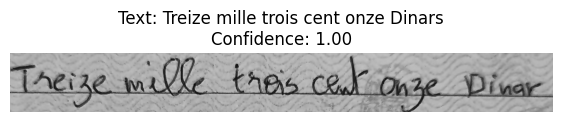

File ./cropped_images/line2.png not found.


In [54]:
# Charger les modèles de traitement
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-stage1')
device = 'cpu'
trained_model = VisionEncoderDecoderModel.from_pretrained('/Users/sarahhaddad/Documents/GitHub/TrOCR/models/model_fr').to(device)

def read_and_show(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: The OCR'd text string.
        confidence: Confidence score of the prediction.
    """
    # Convert image to pixel values using processor
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)

    # Generate text and output logits (for confidence)
    generated_ids = model.generate(pixel_values, output_scores=True, return_dict_in_generate=True)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids.sequences, skip_special_tokens=True)[0]

    # Get logits from the output to calculate confidence
    scores = generated_ids.scores  # These are the logit scores for each token
    confidence = torch.mean(torch.stack([torch.max(torch.softmax(score, dim=-1)) for score in scores])).item()

    return generated_text, confidence

# Fonction pour extraire et afficher le texte extrait
def extract_text(image_path):
    """
    :param image_path: Path to the image to process.

    Displays the image and prints extracted text and confidence.
    """
    try:
        image = read_and_show(image_path)
        text, confidence = ocr(image, processor, trained_model)

        # Show the image with the extracted text and confidence
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(f"Text: {text}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        return text
    except FileNotFoundError:
        print(f"File {image_path} not found.")
        return ''

if arabic_texts1:  # Check if the list is not empty
    print("Le montant est en arabe")
else:
    print("Le montant est en français")
    text_fr1 = extract_text('./cropped_images/line1.png')
    
    # Gérer l'absence de la deuxième ligne
    text_fr2 = extract_text('./cropped_images/line2.png')

# Section : Extraction du montant en chiffre

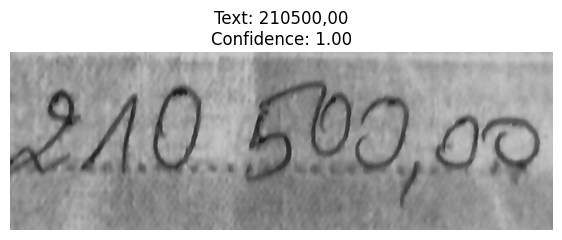

Le montant en chiffres extrait à partir de l'image : 210500,00
Le montant en chiffres corrigé : 210500


In [13]:
trained_model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/projet1/model-num').to(device)

def correct_number_format(number_text):
    """
    Cleans up and corrects the extracted number format.

    Args:
        number_text: The extracted text containing numbers (string).

    Returns:
        corrected_number: Cleaned and correctly formatted number (string).
    """
    # Remove all unnecessary characters except digits, commas, and periods
    clean_text = re.sub(r'[^\d,\.]', '', number_text)

    # Handle cases where there are random points or commas in the number
    # Example: 10.00.000 -> 1000000 or 13311.00 -> 13311
    clean_text = re.sub(r'[,.](?=.*[,\.])', '', clean_text)  # Remove all periods/commas except the last one

    # Handle cases where there is a valid decimal (e.g., "13311.00" or "13311,00")
    if '.' in clean_text or ',' in clean_text:
        # Replace commas with periods to standardize the decimal point
        clean_text = clean_text.replace(',', '.')

        # If the decimal portion is ".00", remove it
        if clean_text.endswith('.00'):
            clean_text = clean_text[:-3]

    # Ensure the result is an integer
    try:
        corrected_number = str(int(clean_text))  # Convert to integer
    except ValueError:
        corrected_number = "Invalid number format"  # In case of conversion error

    return corrected_number


def extract_and_correct_number(image_path):
    """
    Extract the text from an image, clean it up, and correct the number format.

    Args:
        image_path: Path to the image containing the numbers.

    Returns:
        corrected_number: The cleaned and formatted number.
    """
    # Extract the number text from the image
    number_text = extract_text(image_path)
    print(f"Le montant en chiffres extrait à partir de l'image : {number_text }")

    # Correct the extracted number format
    corrected_number = correct_number_format(number_text)

    return corrected_number

# Example usage
image_path_numbers = '/content/cropped_images/numbers.png'
chiffre = extract_and_correct_number(image_path_numbers)
print(f"Le montant en chiffres corrigé : {chiffre}")


## corriger et convertir des nombres écrits en arabe en leur équivalent numérique

In [55]:
class WordToNumber:
    def __init__(self):
        self.word_to_num = {
            'صفر': 0, 'واحد': 1, 'اثنان': 2, 'ثلاثة': 3, 'أربعة': 4, 'خمسة': 5,
            'ستة': 6, 'سبعة': 7, 'ثمانية': 8, 'تسعة': 9, 'عشرة': 10,
            'أحد عشر': 11, 'إثنا عشر': 12, 'ثلاثة عشر': 13, 'أربعة عشر': 14,
            'خمسة عشر': 15, 'ستة عشر': 16, 'سبعة عشر': 17, 'ثمانية عشر': 18,
            'تسعة عشر': 19, 'عشرون': 20, 'ثلاثون': 30, 'أربعون': 40,
            'خمسون': 50, 'ستون': 60, 'سبعون': 70, 'ثمانون': 80, 'تسعون': 90,
            'مائة': 100, 'مائتان': 200, 'ثلاثمائة': 300, 'اربعمائة': 400,
            'خمسمائة': 500, 'ستمائة': 600, 'سبعمائة': 700, 'ثمانيمائة': 800,
            'تسعمائة': 900, 'الف': 1000, 'الفان': 2000, 'مليون': 1000000,
            'مليار': 1000000000
        }
        self.multipliers = {'الف': 1000, 'مليون': 1000000, 'مليار': 1000000000}
        self.currencies = {'دينار'}

    # Calcul de la distance de Levenshtein pour l'autocorrection
    def levenshtein_distance(self, s1, s2):
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)
        if len(s2) == 0:
            return len(s1)
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]

    # Autocorrection du mot en utilisant la distance de Levenshtein
    def autocorrect(self, word):
        if word in self.word_to_num or word in self.multipliers or word in self.currencies:
            return word
        closest_word = min(list(self.word_to_num.keys()) + list(self.multipliers.keys()) + list(self.currencies),
                           key=lambda x: self.levenshtein_distance(word, x))
        return closest_word

    # Convertir les mots arabes en nombre
    def convert(self, arabic_words):
        words = re.findall(r'\w+|[^\w\s]', arabic_words)
        total = 0
        current_num = 0
        currency = None
        for word in words:
            if word in ['و', 'أ']: # Ignorer les mots de liaison
                continue
            corrected_word = self.autocorrect(word) # Corriger les erreurs dans le mot
            print(corrected_word)
            if corrected_word in self.currencies:
                currency = corrected_word # Gérer la détection de la monnaie
            elif corrected_word in self.multipliers:
                if current_num == 0:
                    current_num = 1
                total += current_num * self.multipliers[corrected_word] # Calculer la valeur du multiplicateur
                current_num = 0
            elif corrected_word in self.word_to_num:
                current_num += self.word_to_num[corrected_word]
            else:
                continue
        total += current_num # Ajouter le dernier nombre traité
        return total

## corriger et convertir des nombres écrits en français en leur équivalent numérique

In [67]:
class FrenchAmountConverter:
    def __init__(self):
        self.verifier = FrenchAmountVerifier()
        # Set the language to French for word2number-i18n
        os.environ['w2n.lang'] = 'fr'
        self.w2n_instance = w2n.W2N(lang_param="fr")

    def convert_to_number(self, amount):
        # First, verify and correct the amount
        verified_amount = self.verifier.verify_amount(amount)

        print(verified_amount)

        # Remove the currency word if present
        amount_words = verified_amount.split()
        if amount_words[-1] in ["dinar", "dinars"]:
            amount_words = amount_words[:-1]

        # Join the words back together
        number_words = " ".join(amount_words)

        try:
            # Convert to number using word2number-i18n
            numeric_amount = self.w2n_instance.word_to_num(number_words)
            return numeric_amount
        except ValueError as e:
            print(f"Error converting to number: {e}")
            return None

class FrenchAmountVerifier:
    def __init__(self):
        self.number_words = {
            0: "zéro", 1: "un", 2: "deux", 3: "trois", 4: "quatre", 5: "cinq",
            6: "six", 7: "sept", 8: "huit", 9: "neuf", 10: "dix",
            11: "onze", 12: "douze", 13: "treize", 14: "quatorze", 15: "quinze",
            16: "seize", 20: "vingt", 30: "trente", 40: "quarante", 50: "cinquante",
            60: "soixante", 100: "cent", 1000: "mille", 1000000: "million"
        }
        self.ignore_words = {"et", "de"}
        self.currency_words = {"dinar", "dinars"}

    def levenshtein_distance(self, s1, s2):
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)
        if len(s2) == 0:
            return len(s1)
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]

    def find_closest_word(self, word, word_list):
        return min(word_list, key=lambda x: self.levenshtein_distance(word, x))

    def verify_amount(self, amount):
        words = re.findall(r'\b[\w-]+\b', amount.lower())
        corrected_words = []
        for word in words:
            if '-' in word:
                sub_words = word.split('-')
                corrected_sub_words = []
                for sub_word in sub_words:
                    corrected_sub_words.append(self.process_word(sub_word))
                corrected_words.append('-'.join(corrected_sub_words))
            else:
                corrected_words.append(self.process_word(word))
        return " ".join(corrected_words)

    def process_word(self, word):
        if word in self.ignore_words:
            return word
        elif word in self.number_words.values():
            return word
        elif word in self.currency_words:
            return word
        else:
            # Check if it's a misspelled currency word
            closest_currency = self.find_closest_word(word, self.currency_words)
            if self.levenshtein_distance(word, closest_currency) <= 2:  # Arbitrary threshold
                return closest_currency
            else:
                # If not close to a currency word, treat as a number word
                return self.find_closest_word(word, self.number_words.values())

## Vérification de la langue et conversion

In [68]:
if arabic_texts1:  # Vérifie si arabic_texts1 n'est pas vide
    print("Le montant est en arabe:")
    print("Le montant corrigé :")
    converter = WordToNumber()

    if arabic_texts2:  # Vérifie si arabic_texts2 n'est pas vide
        concatenated_texts = ' '.join(arabic_texts1) + ' ' + ' '.join(arabic_texts2)
    else:
        concatenated_texts = ' '.join(arabic_texts1)

    montant = converter.convert(concatenated_texts)
    #print(f"Concatenated Arabic Texts: {concatenated_texts}")
    print(f"Montant en lettres converti en chiffres : {montant}")
    language = "arabe"
else:
    print("Le montant est en français:")
    print("Le montant corrigé :")
    converter = FrenchAmountConverter()

    # Joindre correctement le texte français
    if isinstance(text_fr1, list):
        concatenated_texts = ' '.join(text_fr1)
    else:
        concatenated_texts = text_fr1

    if text_fr2:
        if isinstance(text_fr2, list):
            concatenated_texts += ' ' + ' '.join(text_fr2)
        else:
            concatenated_texts += ' ' + text_fr2

    #print(f"Concatenated French Text: {concatenated_texts}")

    # Convertir le montant en français
    montant = converter.convert_to_number(concatenated_texts)
    print(f"Montant en lettres converti en chiffres : {montant}")
    language = "français"

Le montant est en français:
Le montant corrigé :


AttributeError: module 'w2n' has no attribute 'W2N'

In [17]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the embeddings (use the last hidden state)
    return outputs.last_hidden_state.mean(dim=1)  # Averaging the token embeddings

# Convert montant to string
montant = str(montant)

print(chiffre)
print(montant)

# Get embeddings for both texts
embedding_words = get_embedding(chiffre)
embedding_numbers = get_embedding(montant)

# Calculate cosine similarity
cosine_similarity = torch.nn.functional.cosine_similarity(embedding_words, embedding_numbers)
similarity_percentage = int(cosine_similarity.item() * 100)
print(f"Similarité entre le montant détecté en chiffres et celui en lettres : {similarity_percentage}%")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

210500
210500
Similarité entre le montant détecté en chiffres et celui en lettres : 100%
